# Keras Data Loaders and Augmentator

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Image-Data-Generator" data-toc-modified-id="Image-Data-Generator-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Image Data Generator</a></span></li><li><span><a href="#Custom-DataGenerator" data-toc-modified-id="Custom-DataGenerator-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Custom DataGenerator</a></span><ul class="toc-item"><li><span><a href="#Train-with-custom-generators" data-toc-modified-id="Train-with-custom-generators-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Train with custom generators</a></span></li><li><span><a href="#Evaluate-Generator" data-toc-modified-id="Evaluate-Generator-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Evaluate Generator</a></span></li><li><span><a href="#Predict-Generator" data-toc-modified-id="Predict-Generator-2.3"><span class="toc-item-num">2.3&nbsp;&nbsp;</span>Predict Generator</a></span></li><li><span><a href="#Example-of-custom-generators-returns" data-toc-modified-id="Example-of-custom-generators-returns-2.4"><span class="toc-item-num">2.4&nbsp;&nbsp;</span>Example of custom generators returns</a></span></li></ul></li></ul></div>

**OPCIONES**
    * ImageDataGenerator + imgaug
    * ImageDataGenerator + tf.keras.layers.experimental.preprocessing

Librerias

* **ImageDataGenerator:**
   * CPU
   * No easy Custom preprocessing techniques
   * From directory
   * https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator?version=nightly
   * https://keras.io/api/preprocessing/image/#imagedatasetfromdirectory-function
   * https://towardsdatascience.com/keras-data-generators-and-how-to-use-them-b69129ed779c
   * https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly
   * https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
   * https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
 
* **imgaug**
     * Specifically, the ***data augmentation generator method*** takes the batches of images generated by a ImageDataGenerator for training or validation and adds to the input images the selected augmentations, preserving an original copy of them to
     * GaussianBlur method, CutOut, CoarseDropout
* **tf.keras.layers.experimental.preprocessing**
    * GPU
    * Lo de Santiago de Twitter
    * https://keras.io/guides/preprocessing_layers/
    * https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing
        
    
    https://www.kaggle.com/cdeotte/dog-autoencoder
    https://vijayabhaskar96.medium.com/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720

In [1]:
import tensorflow as tf 
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [2]:
import pandas as pd
import glob
import random
tf.__version__, tf.test.is_built_with_cuda(), tf.config.experimental.list_physical_devices('GPU')

('2.3.1',
 True,
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

## Image Data Generator

It inclues a easy api, and different ways of data load.

**Downside**: 
* Only reads jpg, png... but it do not read npy files (we have stores numpy files in order to keep the original values of each pixel)
* Preprocessing and augmentation are made in CPU




```python
train_datagen = keras.preprocessing.image.ImageDataGenerator(..., validation_split=0.2) # OJO set validation split

validation_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory(PATH,
                                                 subset='training',
                                                 class_mode='input', #OJOOOO,
                                                 color_mode='grayscale',
                                                 shuffle=True,
                                                 #save_to_dir='dir prueba' para testear el augmentado,
                                                 #save_format='png',
                                                 target_size = (64, 64),
                                                 batch_size = 32)

validation_set = validation_datagen.flow_from_directory(PATH,
                                                        subset='validation',
                                                        class_mode='input', #OJOOOO
                                                        target_size = (64, 64),
                                                        batch_size = 32)
model = create_model()

# steps_per_epoch should be (number of training images total // batch_size) 
# validation_steps should be (number of validation images total // batch_size) 
model.fit(training_set,
          steps_per_epoch = 8000,
          epochs = 5,
          validation_data = validation_set,
          validation_steps = 2000)
```

## Custom DataGenerator
**We made a custom data generator to have mor control in preprocessing and data augmentation**

**Returns a tuple with batch of input images (maybe augmented) on [0] and batch of output images on [1]**

**X images could be augmented. Dimensions = (256,256,1) to be fitted in Convolutional Autoencoder**

```python
import numpy as np
from tf.keras.utils import Sequence

class DataGenerator(Sequence):
    'Generates data for Keras'
    def __init__(self, list_IDs, batch_size=8, dim=(256, 256), n_channels=1, 
                 shuffle=True, std_normalization=False, to_fit=True):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.list_IDs = list_IDs
        self.samples = len(list_IDs)
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.std_normalization = std_normalization
        self.to_fit = to_fit
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.list_IDs) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        list_IDs_temp = [self.list_IDs[k] for k in indexes]

        # Generate data
        batch_x = self.__data_generation(list_IDs_temp)
        
        if self.to_fit:
            batch_x, batch_y = batch_x
        
            return np.stack([
                self._augment(image=x) for x in batch_x
            ], axis=0), np.array(batch_y)
        else:
            return np.stack([
                self._augment(image=x) for x in batch_x
            ], axis=0)


    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.list_IDs))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, list_IDs_temp):
        'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        
         # Generate data
        for i, ID in enumerate(list_IDs_temp):
            #Load
            img = np.load(ID)
            img = np.expand_dims(img, axis=2)
            #Preprocess Sample
            if self.std_normalization:
                img = (img-img.mean())/img.std()
            
            # Store sample 
            X[i,] = img
            
        if self.to_fit:
            return X, X.copy()
        else:
            return X    
        
    
    def _augment(self, image):
        #image = resize(image, (image.shape[0] // 2, image.shape[1] // 2, 1), anti_aliasing=True)
        #TBD
        return image
```

### Train with custom generators

In [3]:
from my_data_loader import DataGenerator

In [4]:
#Partition
train_percentage = 0.85

trainval_files = glob.glob('../IXI-T1/img/train_and_val/*.npy')
random.shuffle(trainval_files)

lim = int(len(trainval_files)*train_percentage)
train_files = trainval_files[:lim]
validation_files = trainval_files[lim:]

test_files = glob.glob('../IXI-T1/img/test/*.npy')

In [5]:
# Parameters
params = {'dim': (256,256),
          'batch_size': 8,
          'n_channels': 1,
          'shuffle': True,
          'std_normalization': True}
# Generators
train_generator = DataGenerator(train_files, **params)
validation_generator = DataGenerator(validation_files, **params)

In [6]:
train_generator.samples, train_generator.samples // train_generator.batch_size

(46285, 5785)

In [7]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from tensorflow.keras.optimizers import RMSprop

  
def build_model(i_shape):
    input_layer = Input(shape=i_shape)

    # encoder
    h = Conv2D(64, (3, 3), activation='relu', padding='same')(input_layer)
    h = MaxPooling2D((2, 2), padding='same')(h)

    # decoder
    h = Conv2D(64, (3, 3), activation='relu', padding='same')(h)
    h = UpSampling2D((2, 2))(h)
    output_layer = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(h)

    return Model(input_layer, output_layer)

autoencoder = build_model((256,256,1))
autoencoder.compile(loss='mse', optimizer=RMSprop())
autoencoder.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 256, 256, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 128, 128, 64)      36928     
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 256, 256, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 256, 256, 1)       577       
Total params: 38,145
Trainable params: 38,145
Non-trainable params: 0
__________________________________________________

In [8]:
train_generator.samples // train_generator.batch_size

5785

In [9]:
STEP_SIZE_TRAIN = train_generator.samples // train_generator.batch_size
STEP_SIZE_VALID = validation_generator.samples // validation_generator.batch_size

'''early_stopping = EarlyStopping(monitor='val_loss',
                                       min_delta=0,
                                       patience=5,
                                       verbose=1, 
                                       mode='auto')'''

from tensorflow.keras.callbacks import CSVLogger
csv_logger = CSVLogger('CHECKtraining.log')
    
autoencoder_train = autoencoder.fit_generator(train_generator,
                                    epochs=2, 
                                    steps_per_epoch = STEP_SIZE_TRAIN,
                                    validation_data = validation_generator, 
                                    validation_steps = STEP_SIZE_VALID,
                                    callbacks=[csv_logger],
                                    use_multiprocessing=True,
                                    workers=16
                                   )


Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/2
5785/5785 [==============================] - 319s 55ms/step - loss: 0.4922 - val_loss: 0.4909
Epoch 2/2
5785/5785 [==============================] - ETA: 0s - loss: 0.4904WARNING:tensorflow:multiprocessing can interact badly with TensorFlow, causing nondeterministic deadlocks. For high performance data pipelines tf.data is recommended.


Exception in thread Thread-19:
Traceback (most recent call last):
  File "c:\users\usuario\.conda\envs\d_mri_autoencoder\lib\threading.py", line 926, in _bootstrap_inner
    self.run()
  File "c:\users\usuario\.conda\envs\d_mri_autoencoder\lib\threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "c:\users\usuario\.conda\envs\d_mri_autoencoder\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 860, in _run
    with closing(self.executor_fn(_SHARED_SEQUENCES)) as executor:
  File "c:\users\usuario\.conda\envs\d_mri_autoencoder\lib\site-packages\tensorflow\python\keras\utils\data_utils.py", line 839, in pool_fn
    initargs=(seqs, None, get_worker_id_queue()))
  File "c:\users\usuario\.conda\envs\d_mri_autoencoder\lib\multiprocessing\context.py", line 119, in Pool
    context=self.get_context())
  File "c:\users\usuario\.conda\envs\d_mri_autoencoder\lib\multiprocessing\pool.py", line 176, in __init__
    self._repopulate_pool()
  File "c:\

5785/5785 [==============================] - 317s 55ms/step - loss: 0.4904 - val_loss: 0.4904


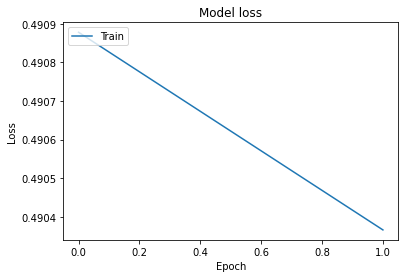

In [10]:
import matplotlib.pyplot as plt
plt.plot(autoencoder_train.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

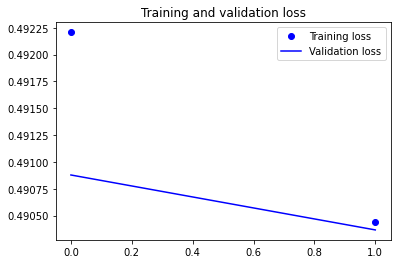

In [11]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(2)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

### Evaluate Generator

### Predict Generator

### Example of custom generators returns

In [12]:
def blank_out(img, percentage=0.05, square = True):
    import numpy as np
    
    img = img.copy()
    blank_out_size =  int(np.prod(img.shape) * percentage)
    if not square:
        max_side_size = img.shape[0]
        min_side_size = np.ceil(blank_out_size/img.shape[0])+1
        
        heigth = np.random.randint(min_side_size, max_side_size) 
        width = int(np.floor(blank_out_size / heigth))
        
    else:
        heigth = int(np.floor(np.sqrt(blank_out_size)))
        width = heigth
    
    y_init_lim = np.random.randint(0, img.shape[0]-heigth)
    x_init_lim = np.random.randint(0, img.shape[1]-width)
    
    img[y_init_lim : y_init_lim+heigth, x_init_lim : x_init_lim+width] = img.min()
    
    return img

In [13]:
params = {'dim': (256,256),
          'batch_size': 2,
          'n_channels': 1,
          'shuffle': True,
          'std_normalization': True,
          'to_fit': True,
          'f_aug':blank_out,
         }
train_generator = DataGenerator(test_files, **params)

In [14]:
batchx, batchy = train_generator.__getitem__(0)

In [15]:
import matplotlib.pyplot as plt

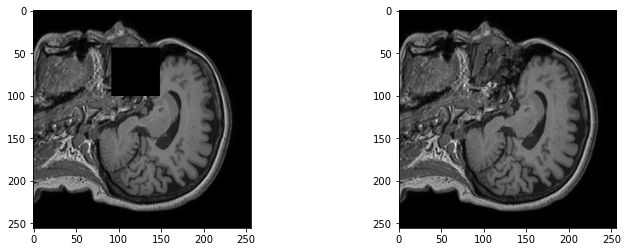

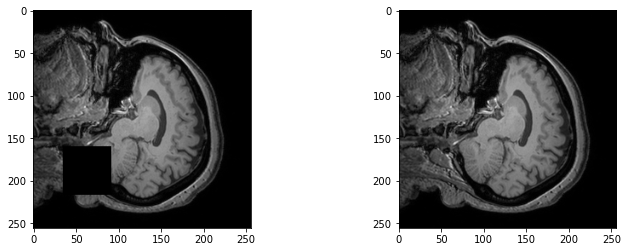

In [16]:
for i in range(2):
    fig, ax = plt.subplots(1,2,figsize = (12,4))
    ax[0].imshow(batchx[i], cmap='gray')
    ax[1].imshow(batchy[i], cmap='gray')
    plt.show()